In [37]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt

# Define spatial grid

In [2]:
rho_min, rho_max, min_delta_rho = 0.0, 5.0, 0.2
z_min, z_max, min_delta_z = -3.0, 6.0, 0.2

In [3]:
assert (rho_min >= 0) and (rho_min < rho_max)
assert (z_min < z_max)

def get_N_grid(xmin, xmax, min_delta_x): 
    return int((xmax-xmin+min_delta_x)/min_delta_x) + 1

N_rho = get_N_grid(rho_min, rho_max, min_delta_rho)
rho_arr = np.linspace(rho_min, rho_max, N_rho)
delta_rho = rho_arr[1] - rho_arr[0]

N_z = get_N_grid(z_min, z_max, min_delta_z)
z_arr = np.linspace(z_min, z_max, N_z)
delta_z = z_arr[1] - z_arr[0]

drho, dz = delta_rho, delta_z  # aliasing

grid_shape = (N_rho, N_z)

## Define 2D meshgrid

In [4]:
Rho, Z = np.meshgrid(rho_arr, z_arr, indexing='ij')

# Construct a boundary condition array

## Define a conductor

In [5]:
l = 2.0
z_c = 0.0
R = 1.5
V0 = 1.0
assert z_min < z_c - l/2 and z_c + l/2 < z_max

In [6]:
assert rho_min == 0  # so that it can be a cylinder
s1 = [(rho, z_c+l/2) for rho in np.linspace(0, R, 5)]
# [1:-1] for excluding end points since they have already been included
s2 = [(R, z) for z in np.linspace(z_c-l/2,z_c+l/2, 6)[1:-1]]
s3 = [(rho, z_c-l/2) for rho in np.linspace(0, R, 5)]

surf_points = np.array([*s1, *s2, *s3])

In [32]:
# figsu, axsu = plt.subplots()
# axsu.plot(surf_points[:,0], surf_points[:,1],'.')
# axsu.set_aspect(1.0)

# figsu.savefig("surface-points-cylinder-test-0.png")

# [assumption] each conductors should be separated a bit - in order to prevent some numerical artifacts due to possible discontinuity

In [28]:
bd_cond = np.ma.array(np.full(grid_shape, -1e10, dtype=float), mask=True)

# Bounding box
bd_cond.mask[:,[0,-1]] = False
bd_cond[:,[0,-1]] = 0.0

bd_cond.mask[-1,:] = False
bd_cond[-1,:] = 0.0

if rho_arr[0] > 0: 
    bd_cond.mask[0,:] = False
    bd_cond[0,:] = 0.0

# a cylinder
cy_mask = (Rho <= R) & ((z_c-l/2) <= Z) & (Z <= (z_c+l/2))
bd_cond.mask[cy_mask] = False
bd_cond[cy_mask] = V0

In [91]:
V = np.empty(bd_cond.shape, dtype=float)
V[:] = np.random.rand(*bd_cond.shape)
V[~bd_cond.mask] = bd_cond[~bd_cond.mask]

In [106]:
N_near_point = 6
near_point_arr = np.empty((surf_points.shape[0], N_near_point, 2))
near_point_V_arr = np.empty((surf_points.shape[0], N_near_point), dtype=float)
for pt_idx, (rho,z) in enumerate(surf_points):
    Dist = sqrt(np.square(Rho-rho)+np.square(Z-z))
    indice = np.argpartition(Dist[bd_cond.mask].flatten(), N_near_point)[:N_near_point]
    near_point_arr[pt_idx,:,0] = Rho[bd_cond.mask].flatten()[indice]
    near_point_arr[pt_idx,:,1] = Z[bd_cond.mask].flatten()[indice]
    
    near_point_V_arr[pt_idx,:] = V[bd_cond.mask].flatten()[indice]

In [144]:
A

array([[1.        , 0.19230769, 0.2       , 0.01849112, 0.03846154,
        0.02      ],
       [1.        , 0.        , 0.2       , 0.        , 0.        ,
        0.02      ],
       [1.        , 0.        , 0.4       , 0.        , 0.        ,
        0.08      ],
       [1.        , 0.38461538, 0.2       , 0.0739645 , 0.07692308,
        0.02      ],
       [1.        , 0.19230769, 0.4       , 0.01849112, 0.07692308,
        0.08      ],
       [1.        , 0.38461538, 0.4       , 0.0739645 , 0.15384615,
        0.08      ]])

In [155]:
A, _ = np.meshgrid(aa,aa)

In [146]:
A[_ind,_ind]

array([1.        , 0.        , 0.4       , 0.0739645 , 0.07692308])

In [161]:
aa, = np.where(_ind)

In [167]:
A[[0,1,2,5]][:,[0,1,2,5]]

array([[1.        , 0.19230769, 0.2       , 0.02      ],
       [1.        , 0.        , 0.2       , 0.02      ],
       [1.        , 0.        , 0.4       , 0.08      ],
       [1.        , 0.38461538, 0.4       , 0.08      ]])

In [163]:
np.delete(np.delete(A, [0,1,2,5], axis=0))

array([[1.        , 0.38461538, 0.2       , 0.0739645 , 0.07692308,
        0.02      ],
       [1.        , 0.19230769, 0.4       , 0.01849112, 0.07692308,
        0.08      ]])

In [174]:
for i in range(surf_points.shape[0]):
    rho_s, z_s = surf_points[i]
    
    A = np.empty((N_near_point, N_near_point))
    A[:,0] = 1.0
    A[:,1] = near_point_arr[i,:,0] - rho_s
    A[:,2] = near_point_arr[i,:,1] - z_s
    A[:,3] = 0.5 * np.square(near_point_arr[i,:,0] - rho_s)
    A[:,4] = (near_point_arr[i,:,0] - rho_s) * (near_point_arr[i,:,1] - z_s)
    A[:,5] = 0.5 * np.square(near_point_arr[i,:,1] - z_s)
    
    Q, R = np.linalg.qr(A.transpose())
    _ind, = np.where(~(np.abs(R) < 1e-15).all(axis=1))
    AA = A[_ind][:,_ind]
    bb = near_point_V_arr[i][_ind]
#     N_indep = np.sum()
    
    print(np.linalg.det(AA))
    
    try:
        np.linalg.solve(AA,bb)
    except: 
        print(AA)
        print(_ind)
        print(R)
        raise Exception("Failed to evaluate V, dxV, dyV")
    
#     for (rho, z) in near_point_arr[i]:

-5.470746822590264e-05
0.0
[[ 1.00000000e+00  2.01923077e-01  2.00000000e-01  2.03864645e-02
   4.03846154e-02  2.00000000e-02]
 [ 1.00000000e+00 -1.82692308e-01  2.00000000e-01  1.66882396e-02
  -3.65384615e-02  2.00000000e-02]
 [ 1.00000000e+00  9.61538462e-03  2.00000000e-01  4.62278107e-05
   1.92307692e-03  2.00000000e-02]
 [ 1.00000000e+00  9.61538462e-03  4.00000000e-01  4.62278107e-05
   3.84615385e-03  8.00000000e-02]
 [ 1.00000000e+00 -3.75000000e-01  2.00000000e-01  7.03125000e-02
  -7.50000000e-02  2.00000000e-02]
 [ 1.00000000e+00 -1.82692308e-01  4.00000000e-01  1.66882396e-02
  -7.30769231e-02  8.00000000e-02]]
[0 1 2 3 4 5]
[[-1.04077829e+00 -9.63101207e-01 -1.00157755e+00 -1.04123793e+00
  -9.25349260e-01 -1.00126919e+00]
 [ 0.00000000e+00  3.84481600e-01  1.92345486e-01  1.99973351e-01
   5.76408343e-01  3.99502940e-01]
 [ 0.00000000e+00  0.00000000e+00 -1.84872802e-02 -1.92211043e-02
   5.54618406e-02 -6.62719214e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00

Exception: Failed to evaluate V, dxV, dyV

In [134]:
Q, R = np.linalg.qr(A)

In [135]:
(np.abs(R) < 1e-15).all(axis=1)

array([False, False, False, False, False,  True])

In [136]:
R

array([[-2.44948974e+00, -4.71055720e-01, -7.34846923e-01,
        -7.54896987e-02, -1.41316716e-01, -1.22474487e-01],
       [ 0.00000000e+00,  3.84615385e-01, -2.77555756e-17,
         7.39644970e-02,  1.15384615e-01, -6.93889390e-18],
       [ 0.00000000e+00,  0.00000000e+00, -2.44948974e-01,
         1.04083409e-17, -4.71055720e-02, -7.34846923e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.13517111e-02, -2.77555756e-17, -2.74000087e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -3.84615385e-02,  3.86931929e-18],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.60521660e-17]])

In [119]:
np.linalg.det(A[:-1,:-1])

-5.470746822590264e-05

In [120]:
np.linalg.det(A)

0.0

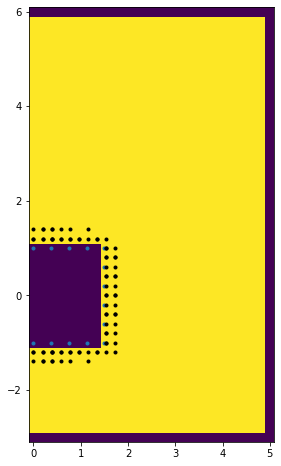

In [93]:
from vis.plot import construct_catesian_mesh_for_pcolormesh
Rho_mesh, Z_mesh = construct_catesian_mesh_for_pcolormesh(rho_arr, z_arr)

figg ,axx = plt.subplots(figsize=(6,8))
axx.pcolormesh(Rho_mesh, Z_mesh, bd_cond.mask)
axx.set_aspect(1.0)
axx.plot(surf_points[:,0], surf_points[:,1],'.')
# axx.imshow(bd_cond.mask)

for i in range(surf_points.shape[0]):
    for (rho, z) in near_point_arr[i]:
        axx.plot(rho,z,'.',color='black')

# figg.savefig("mask-with-surf-and-near-points-test-0.png")

# Get normal E (.. well, there would only left normal component though) and eval charge dist.

# Auto stop by checking convergence

In [34]:
c1 = 1.0 / (4.0 / drho**2 + 2.0 / dz**2)
c2 = 1.0 / (2.0/drho**2 + 2.0/dz**2)


for _ in range(100):
    
    V[0,1:-1] = c1 * (
        4.0 / drho**2 * V[1,1:-1]
        + 1.0 / dz**2 * (V[0,2:] + V[0,:-2])
    )

    V[1:-1,1:-1] = c2 * (
        1.0/drho**2 * (V[2:,1:-1] + V[:-2,1:-1]) 
        + (1.0/2.0/drho /rho_arr[1:-1] * (V[2:,1:-1] - V[:-2,1:-1]).transpose()).transpose()
        + 1.0/dz**2 * (V[1:-1,2:] + V[1:-1,:-2])
    )
    
    V[~bd_cond.mask] = bd_cond[~bd_cond.mask]

# Eval and Draw E field line

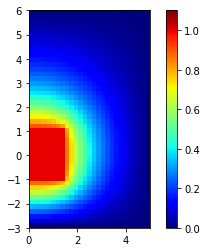

In [35]:
fig, ax = plt.subplots()
img = ax.imshow(V.transpose(), origin='lower', extent=(rho_min,rho_max,z_min,z_max), cmap='jet', vmax=1.1)
cb = fig.colorbar(img, ax=ax)

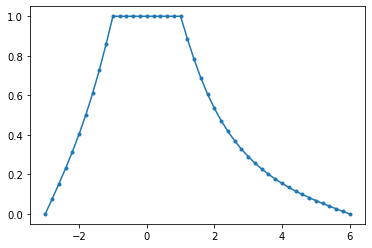

In [42]:
figs, axs = plt.subplots()
axs.plot(z_arr, V[4], '.-')

In [37]:
fig_filename = "single-cylinder-V0={:.3f}-test-0.png".format(V0)
print(fig_filename)
# fig.savefig(fig_filename)

single-cylinder-V0=1.000-test-0.png
